# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

#plotter = TrainSchedulePlotter(requested_schedule, line)
#plotter.plot(main_title="Peticiones RUs (25)", save_path=Path('../figures/requested_schedule.pdf'))

Services:  25


{'0_2024-06-25-17.40': {'Zaragoza': [1060.0, 1061.0], 'Lleida': [1107.0, 1109.0], 'Tarragona': [1138.0, 1140.0], 'Barcelona': [1179.0, 1179.0]}, '1_2024-06-25-14.32': {'Madrid': [872.0, 872.0], 'Zaragoza': [969.0, 970.0], 'Tarragona': [1042.0, 1044.0], 'Barcelona': [1094.0, 1094.0]}, '2_2024-06-25-15.04': {'Madrid': [904.0, 904.0], 'Barcelona': [1066.0, 1066.0]}, '3_2024-06-25-13.47': {'Madrid': [827.0, 827.0], 'Zaragoza': [911.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1354.0, 1354.0], 'Barcelona': [1522.0, 1522.0]}, '5_2024-06-25-12.09': {'Lleida': [729.0, 731.0], 'Barcelona': [802.0, 802.0]}, '6_2024-06-25-2.10': {'Madrid': [130.0, 130.0], 'Zaragoza': [209.0, 210.0], 'Tarragona': [269.0, 271.0], 'Barcelona': [311.0, 311.0]}, '7_2024-06-25-8.02': {'Madrid': [482.0, 482.0], 'Barcelona': [662.0, 662.0]}, '8_2024-06-25-8.51': {'Madrid': [531.0, 531.0], 'Zaragoza': [629.0, 630.0], 'Lleida': [689.0, 692.0], 'Barcelona': [781.0, 781.0]}, '9_2024-06-25-15.2

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


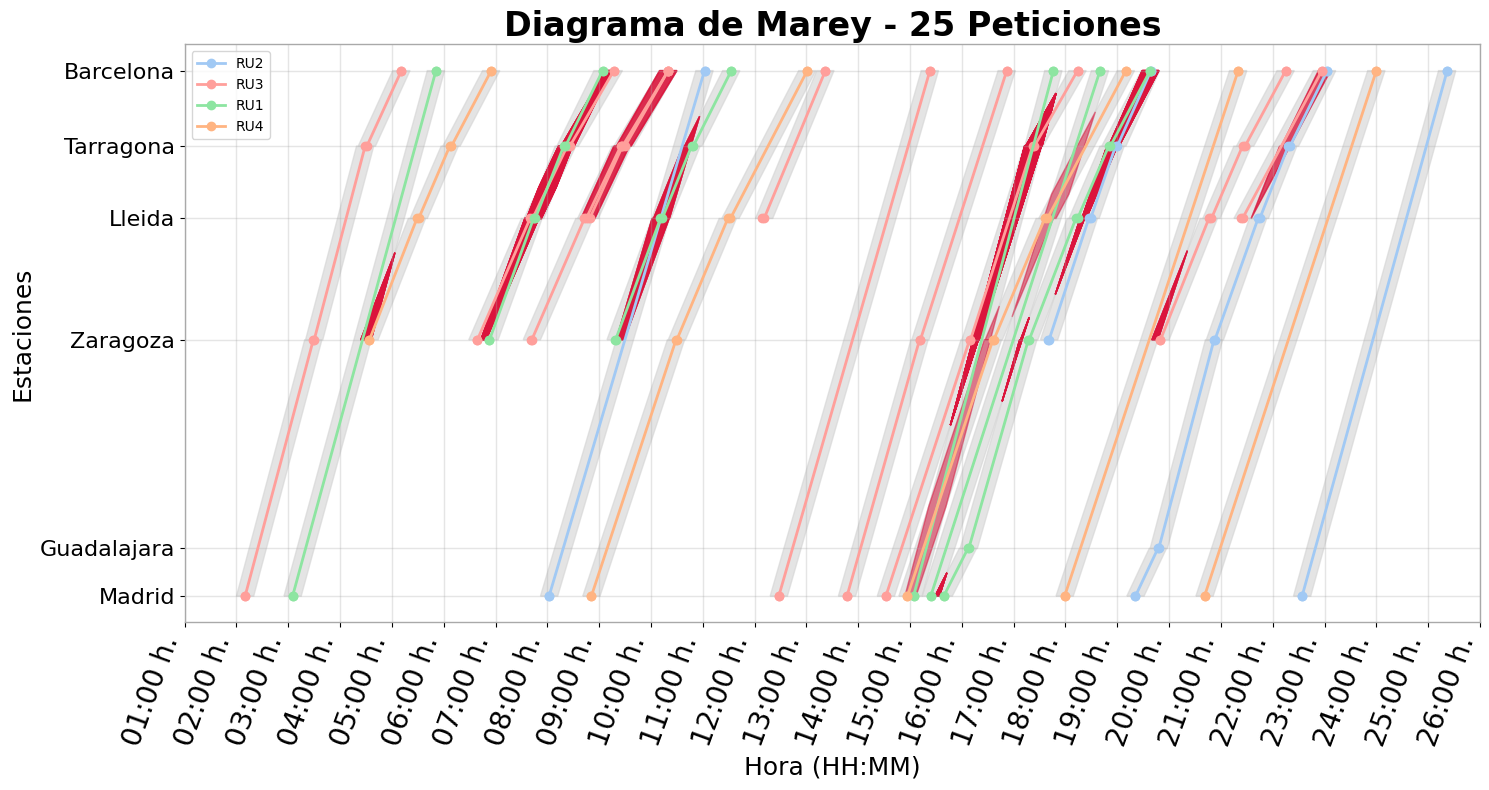

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_25.pdf'))

In [7]:
#pr = profile.Profile()
#pr.enable()
import random

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50,
            global_seed: int=21
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    random.seed(global_seed)
    
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=random.randint(0, 1000))
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

## 1. Chaotic vs Normal GSA

In [8]:
runs = 11
population = 20
iters = 50
verbosity = False
rbs_hist = {}

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, rbs_hist[chaotic_constant] = run_gsa(chaotic_constant=chaotic_constant,
                                                           runs=runs,
                                                           population_size=population,
                                                           iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Running GSA with chaotic constant:  False
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11


## 2. Results analysis

In [9]:
reports_path = Path('../reports/')

# Save df_gcc and df_gpp
df_gcc.to_csv(reports_path / 'gsa/df_gcc_25.csv', index=False)

In [10]:
df_gpp.to_csv(reports_path / 'gsa/df_gpp_25.csv', index=False)

In [11]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [12]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,3591.713665,3557.283637,3578.037643,3673.713002,3512.751767,3643.874645,3597.899976,3580.451247,...,3533.083088,3548.813182,3491.633966,3633.06356,3501.914587,3525.807207,3662.206855,3493.858001,3508.28625,True
1,1,1,3563.576424,3462.974056,3398.994637,3456.343537,3649.7408,3476.246349,3345.749766,3508.003603,...,3526.050916,3707.095889,3609.309189,3499.082563,3511.640668,3541.89559,3398.706032,3492.41278,3677.940416,True
2,1,2,3544.453307,3461.944885,3435.348268,3810.934696,3621.132279,3460.854756,3421.065869,3595.276321,...,3570.217634,3706.628118,3558.538972,3536.761375,3509.865345,3538.750267,3380.599109,3662.746581,3536.886804,True
3,1,3,3768.211017,3672.677612,3562.655011,3658.187989,3673.307121,3679.420328,3568.780411,3714.695719,...,3632.734542,3660.46573,3579.284819,3673.397246,3651.422312,3670.240339,3740.896715,3700.747121,3612.220712,True
4,1,4,3668.865313,3756.830997,3879.6629,3786.455231,3689.120543,3715.66798,3816.466616,3868.702288,...,3820.879911,3625.498932,3809.082355,3647.074104,3694.609443,3837.747969,3790.467989,3798.122605,3562.147002,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,11,45,3562.034647,3628.759898,3586.661242,3709.25792,3761.366779,3580.117238,3641.248113,3459.799538,...,3736.148188,3496.081113,3640.322132,3562.222526,3597.0485,3594.85341,3755.749103,3585.051332,3592.019323,False
46,11,46,3562.034647,3628.759898,3586.661242,3709.25792,3761.366779,3580.117238,3641.248113,3459.799538,...,3736.148188,3496.081113,3640.322132,3562.222526,3597.0485,3594.85341,3755.749103,3585.051332,3592.019323,False
47,11,47,3562.034647,3628.759898,3586.661242,3709.25792,3761.366779,3580.117238,3641.248113,3459.799538,...,3736.148188,3496.081113,3640.322132,3562.222526,3597.0485,3594.85341,3755.749103,3585.051332,3592.019323,False
48,11,48,3562.034647,3628.759898,3586.661242,3709.25792,3761.366779,3580.117238,3641.248113,3459.799538,...,3736.148188,3496.081113,3640.322132,3562.222526,3597.0485,3594.85341,3755.749103,3585.051332,3592.019323,False


In [13]:
# Save df_pop
df_pop.to_csv(reports_path / 'gsa/df_pop_25.csv', index=False)

In [14]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,3591.713665,True,ID_real_0
1,1,0,3557.283637,True,ID_real_1
2,1,0,3578.037643,True,ID_real_2
3,1,0,3673.713002,True,ID_real_3
4,1,0,3512.751767,True,ID_real_4
...,...,...,...,...,...
21995,11,49,3597.048500,False,ID_real_15
21996,11,49,3594.853410,False,ID_real_16
21997,11,49,3755.749103,False,ID_real_17
21998,11,49,3585.051332,False,ID_real_18


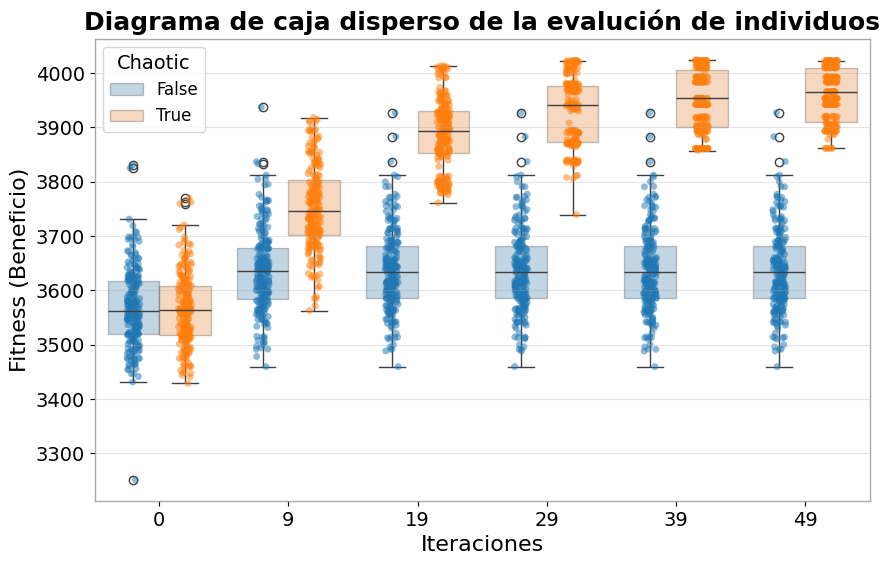

In [15]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_25.pdf'))

In [16]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,3487.556783,0,0.092985,"[False, True, False, True, True, True, True, F...","[1054, 1103, 1141, 869, 968, 1042, 906, 834, 9...",True
1,1,1,3673.713002,0,0.355254,"[False, True, False, True, True, True, True, F...","[1061.0, 1109.0, 1143.0, 872.0, 973.0, 1049.0,...",True
2,1,2,3707.095889,0,0.619052,"[False, True, False, True, True, True, True, F...","[1060, 1112, 1143, 871, 971, 1048, 904, 821, 9...",True
3,1,3,3810.934696,0,0.880254,"[False, True, False, True, True, True, True, F...","[1059, 1110, 1146, 869, 967, 1049, 906, 828, 9...",True
4,1,4,3892.496799,0,1.141061,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1144, 871, 969, 1049, 904, 826, 9...",True
...,...,...,...,...,...,...,...,...
45,11,45,3764.252491,0,11.528579,"[False, True, False, True, True, False, True, ...","[1060.0, 1112.0, 1147.0, 868.0, 972.0, 1048.0,...",False
46,11,46,3764.252491,0,11.769331,"[False, True, False, True, True, False, True, ...","[1060.0, 1112.0, 1147.0, 868.0, 972.0, 1048.0,...",False
47,11,47,3764.252491,0,12.011791,"[False, True, False, True, True, False, True, ...","[1060.0, 1112.0, 1147.0, 868.0, 972.0, 1048.0,...",False
48,11,48,3764.252491,0,12.253534,"[False, True, False, True, True, False, True, ...","[1060.0, 1112.0, 1147.0, 868.0, 972.0, 1048.0,...",False


In [17]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU2,RU4,RU1,RU3
0,1,4026.801327,12.167137,18,33.0,121.0,50.0 %,90.0 %,33.33 %,100.0 %
8,9,4018.059015,12.598791,17,22.0,90.0,50.0 %,80.0 %,50.0 %,80.0 %
2,3,4009.826180,12.234026,18,33.0,115.0,50.0 %,90.0 %,33.33 %,100.0 %
9,10,3992.721504,12.481354,17,22.0,102.0,50.0 %,80.0 %,33.33 %,100.0 %
6,7,3983.646723,12.622037,17,26.0,99.0,50.0 %,80.0 %,33.33 %,100.0 %
10,11,3965.664485,12.336617,18,48.0,103.0,50.0 %,90.0 %,50.0 %,80.0 %
1,2,3953.466642,12.229874,17,23.0,111.0,50.0 %,80.0 %,33.33 %,100.0 %
5,6,3942.244809,12.396759,17,16.0,110.0,50.0 %,90.0 %,33.33 %,80.0 %
4,5,3920.168404,12.345905,17,28.0,102.0,50.0 %,80.0 %,33.33 %,100.0 %
3,4,3901.375666,12.301451,17,29.0,127.0,50.0 %,80.0 %,50.0 %,80.0 %


In [18]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU2 & RU4 & RU1 & RU3 \\\\\n\\midrule\n0 & 1 & 4026.801327 & 12.167137 & 18 & 33.000000 & 121.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n8 & 9 & 4018.059015 & 12.598791 & 17 & 22.000000 & 90.000000 & 50.0 % & 80.0 % & 50.0 % & 80.0 % \\\\\n2 & 3 & 4009.826180 & 12.234026 & 18 & 33.000000 & 115.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n9 & 10 & 3992.721504 & 12.481354 & 17 & 22.000000 & 102.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n6 & 7 & 3983.646723 & 12.622037 & 17 & 26.000000 & 99.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n10 & 11 & 3965.664485 & 12.336617 & 18 & 48.000000 & 103.000000 & 50.0 % & 90.0 % & 50.0 % & 80.0 % \\\\\n1 & 2 & 3953.466642 & 12.229874 & 17 & 23.000000 & 111.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n5 & 6 & 3942.244809 & 12.396759 & 17 & 16.000000 & 110.000000 & 50.0 % & 90.0 % & 3

In [19]:
def get_gsa_table_results(chaotic: bool = True) -> pd.DataFrame:
    service_tsps = {service.id: service.tsp.name for service in supply.services}
    columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
    columns += set(service_tsps.values())
    
    summary_df = pd.DataFrame(columns=columns)
    
    df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == chaotic]
    run_grouped_df = df_train_chaotic.groupby('Run')
    
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data
    
    return summary_df.sort_values('Revenue', ascending=False)

summary_df_nc = get_gsa_table_results(chaotic=False)
display(summary_df_nc)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU2,RU4,RU1,RU3
9,10,3937.418246,12.482052,17,50.0,100.0,50.0 %,80.0 %,33.33 %,100.0 %
7,8,3885.154284,12.234473,16,35.0,92.0,50.0 %,80.0 %,33.33 %,80.0 %
0,1,3853.695384,12.364926,16,29.0,99.0,50.0 %,80.0 %,33.33 %,80.0 %
5,6,3830.848408,12.334033,16,15.0,104.0,50.0 %,70.0 %,50.0 %,80.0 %
6,7,3789.190325,12.340765,16,41.0,119.0,50.0 %,70.0 %,33.33 %,100.0 %
2,3,3785.362234,12.330921,16,40.0,104.0,50.0 %,80.0 %,33.33 %,80.0 %
4,5,3771.383202,12.452558,17,45.0,112.0,50.0 %,80.0 %,33.33 %,100.0 %
3,4,3766.230909,12.345188,16,34.0,146.0,50.0 %,80.0 %,33.33 %,80.0 %
10,11,3764.252491,12.498460,16,31.0,115.0,50.0 %,80.0 %,33.33 %,80.0 %
8,9,3729.100557,12.183821,16,45.0,100.0,50.0 %,80.0 %,33.33 %,80.0 %


In [20]:
summary_df_nc.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU2 & RU4 & RU1 & RU3 \\\\\n\\midrule\n9 & 10 & 3937.418246 & 12.482052 & 17 & 50.000000 & 100.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n7 & 8 & 3885.154284 & 12.234473 & 16 & 35.000000 & 92.000000 & 50.0 % & 80.0 % & 33.33 % & 80.0 % \\\\\n0 & 1 & 3853.695384 & 12.364926 & 16 & 29.000000 & 99.000000 & 50.0 % & 80.0 % & 33.33 % & 80.0 % \\\\\n5 & 6 & 3830.848408 & 12.334033 & 16 & 15.000000 & 104.000000 & 50.0 % & 70.0 % & 50.0 % & 80.0 % \\\\\n6 & 7 & 3789.190325 & 12.340765 & 16 & 41.000000 & 119.000000 & 50.0 % & 70.0 % & 33.33 % & 100.0 % \\\\\n2 & 3 & 3785.362234 & 12.330921 & 16 & 40.000000 & 104.000000 & 50.0 % & 80.0 % & 33.33 % & 80.0 % \\\\\n4 & 5 & 3771.383202 & 12.452558 & 17 & 45.000000 & 112.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n3 & 4 & 3766.230909 & 12.345188 & 16 & 34.000000 & 146.000000 & 50.0 % & 80.0 % & 33.3

In [21]:
# Global status

def get_gsa_global_status(df: pd.DataFrame):
    run_grouped_df = df.groupby('Run')
    print("Global GSA status:")
    
    # Execution time (mean and std.)
    run_times = run_grouped_df['ExecutionTime'].last()
    print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
    print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
    
    # Revenue (mean and std.)
    run_revenues = run_grouped_df['Fitness'].last()
    print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
    
    # Scheduled trains (mean and std.)
    run_trains = run_grouped_df['Discrete'].last().apply(sum)
    print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
    
    runs_best_solution_history = dict(sorted(rbs_hist[True].items(),
                                             key=lambda x: x[1][1]))
    
    q2_solution_index = np.floor(runs // 2).astype(int)
    gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]
    
    print(f"\tMedian solution: Run {gsa_solution[0]}")
    max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
    print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
    
    return gsa_solution

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
gsa_solution = get_gsa_global_status(df_train_chaotic)

Global GSA status:
	Total execution time: 136.4578 s.
	Execution Time (by run) - Mean: 12.4053 s. - Std: 0.1846 s.
	Revenue - Mean: 3964.3369 - Std: 46.4153
	Scheduled Trains - Mean: 17.0 - Std: 0.0
	Median solution: Run 11
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


In [58]:
((3964.3369 - 3802.4911) / 3802.4911) * 100

4.256309764932772

In [22]:
df_train_nc = df_gcc[df_gcc['chaotic_constant'] == False]
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 135.8882 s.
	Execution Time (by run) - Mean: 12.3535 s. - Std: 0.0962 s.
	Revenue - Mean: 3802.4911 - Std: 67.6472
	Scheduled Trains - Mean: 16.0 - Std: 0.0
	Median solution: Run 11
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible


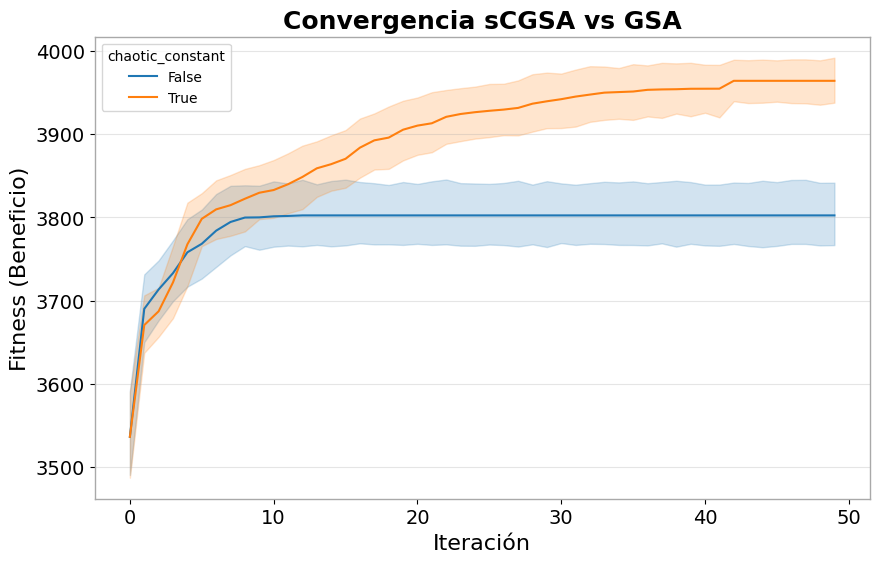

In [23]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="Convergencia sCGSA vs GSA",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              save_path=Path('../reports/gsa/gsa_convergence_25.pdf'))

In [24]:
from scipy import stats

fitness_sCGSA = summary_df['Revenue'].values
fitness_GSA = summary_df_nc['Revenue'].values

fitness_sCGSA, fitness_GSA

(array([4026.80132711, 4018.05901504, 4009.82617958, 3992.72150408,
        3983.64672333, 3965.66448513, 3953.46664163, 3942.24480939,
        3920.16840426, 3901.37566592, 3893.73167503]),
 array([3937.4182462 , 3885.15428412, 3853.69538352, 3830.84840788,
        3789.19032455, 3785.36223404, 3771.3832019 , 3766.23090857,
        3764.25249088, 3729.10055728, 3714.76586274]))

In [25]:
stat, p_value = stats.wilcoxon(fitness_sCGSA, fitness_GSA)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0009765625


In [26]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/gsa_results/ supply_config_gsa


In [27]:
final_supply = Supply.from_yaml(supply_config_file)

{'1_2024-06-25-14.32': {'Madrid': [868.0, 868.0], 'Zaragoza': [965.0, 971.0], 'Tarragona': [1043.0, 1045.0], 'Barcelona': [1095.0, 1095.0]}, '3_2024-06-25-13.47': {'Madrid': [826.0, 826.0], 'Zaragoza': [910.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1358.0, 1358.0], 'Barcelona': [1526.0, 1526.0]}, '5_2024-06-25-12.09': {'Lleida': [737.0, 737.0], 'Barcelona': [808.0, 808.0]}, '6_2024-06-25-2.10': {'Madrid': [130.0, 130.0], 'Zaragoza': [209.0, 211.0], 'Tarragona': [270.0, 272.0], 'Barcelona': [312.0, 312.0]}, '8_2024-06-25-8.51': {'Madrid': [532.0, 532.0], 'Zaragoza': [630.0, 637.0], 'Lleida': [696.0, 699.0], 'Barcelona': [788.0, 788.0]}, '10_2024-06-25-12.28': {'Madrid': [749.0, 749.0], 'Barcelona': [924.0, 924.0]}, '11_2024-06-25-3.05': {'Madrid': [176.0, 176.0], 'Barcelona': [342.0, 342.0]}, '12_2024-06-25-6.38': {'Zaragoza': [399.0, 399.0], 'Lleida': [460.0, 467.0], 'Tarragona': [507.0, 514.0], 'Barcelona': [565.0, 565.0]}, '13_2024-06-25-15.39': {'M

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


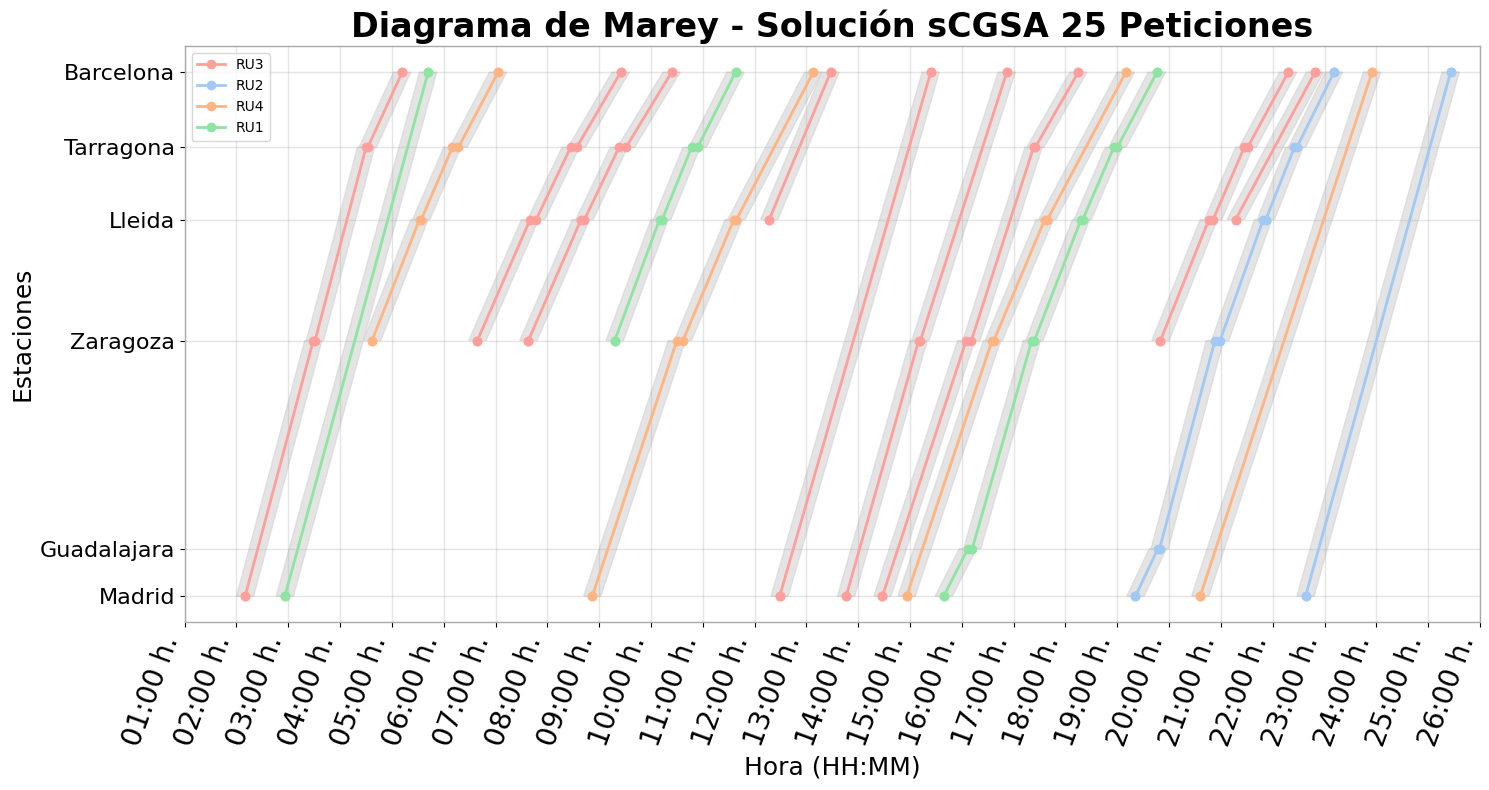

In [28]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - Solución sCGSA 25 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_sol_25.pdf'))

In [29]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25.yml')

PosixPath('../reports/gsa/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat

In [31]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path,
                seed=21)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output_25.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output_25.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: Encontraron algún billete útil, pero no pudieron comprar. - Passengers: 4420
	Status: Compraron un billete diferente al de mayor utilidad. - Passengers: 3255
	Status: Compraron el billete con mayor utilidad. - Passengers: 1257
	Status: No encontraron ningún billete útil. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  4512
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 815 - Percentage: 18.06 %
		Seat: Turista - Passengers: 3000 - Percentage: 66.49 %
		Seat: TuristaPlus - Passengers: 697 - Percentage: 15.45 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  4512
	Tickets sold by purchase date and seat type: 
		Date: 2024-06-11
			Seat: Premium - Number of tickets sold: 90
			Seat: Turista - Number of tickets sold: 220
			Seat: TuristaPlus - Number of tickets sold: 172
		Date: 2024-06-12
			Seat: Premium - Number of tickets sold: 93
			Seat: Turista - Number of tickets sold: 193
			Seat: TuristaP

In [32]:
shutil.copyfile(f'{robin_save_path}output_25.csv', f'../reports/robin/output_25.csv')

'../reports/robin/output_25.csv'

In [78]:
# Open output csv
output_df = pd.read_csv(f'{robin_save_path}output_25.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/robin/output_25.csv'

In [79]:
df = output_df.copy()
df['route'] = df['departure_station'] + '-' + df['arrival_station']

# Drop columns with empty 'service' values
df = df.dropna(subset=['service'])

# Agrupar por 'user_pattern' y 'route', y contar el número de ocurrencias
grouped = df.groupby(['user_pattern', 'route']).size().reset_index(name='passengers')

# Crear el diccionario final
passenger_dict = {}
for _, row in grouped.iterrows():
    user_pattern = row['user_pattern']
    route = row['route']
    passengers = row['passengers']
    
    if user_pattern not in passenger_dict:
        passenger_dict[user_pattern] = {}
    
    passenger_dict[user_pattern][route] = passengers

In [80]:
# Convertir el diccionario en un DataFrame
df = pd.DataFrame(passenger_dict).T

# Calcular el número total de pasajeros para cada tipo (user_pattern)
df['Total Pasajeros'] = df.sum(axis=1)

# Calcular el número total de pasajeros en general
total_passengers = df['Total Pasajeros'].sum()

# Añadir una fila para el total general
df.loc['Total General'] = df.sum(axis=0)
df.at['Total General', 'Total Pasajeros'] = total_passengers

In [81]:
df

,Madrid-Barcelona,Madrid-Zaragoza,Zaragoza-Barcelona,Total Pasajeros
Aventurero,52.0,30.0,54.0,136.0
Business,434.0,83.0,98.0,615.0
Estudiante,NaN,128.0,125.0,253.0
Turista,1689.0,364.0,393.0,2446.0
Turista de Eventos,857.0,117.0,88.0,1062.0
Total General,3032.0,722.0,758.0,4512.0


{'Turista': {'TuristaPlus': 677, 'Turista': 1769}, 'Turista de Eventos': {'Turista': 511, 'Premium': 551}, 'Aventurero': {'Turista': 50, 'Premium': 66, 'TuristaPlus': 20}, 'Business': {'Premium': 198, 'Turista': 417}, 'Estudiante': {'Turista': 253}}


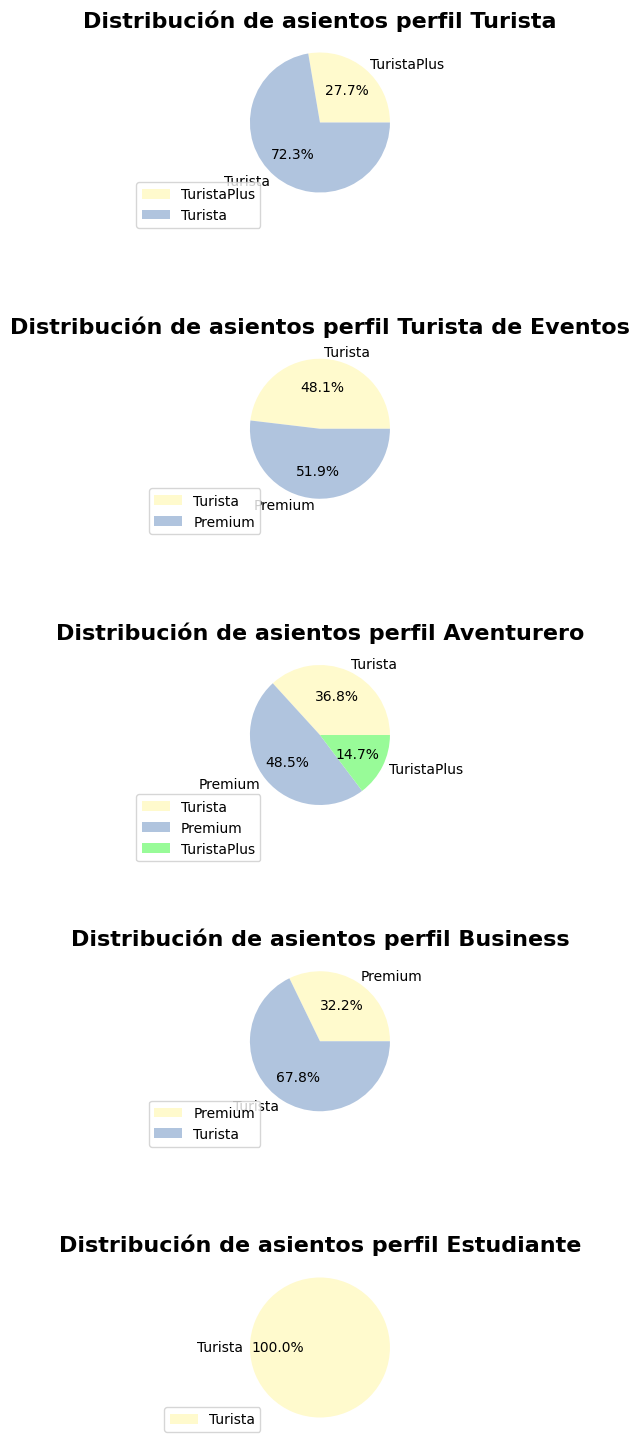

In [37]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../reports/robin/users_seat_pie_chart.pdf')

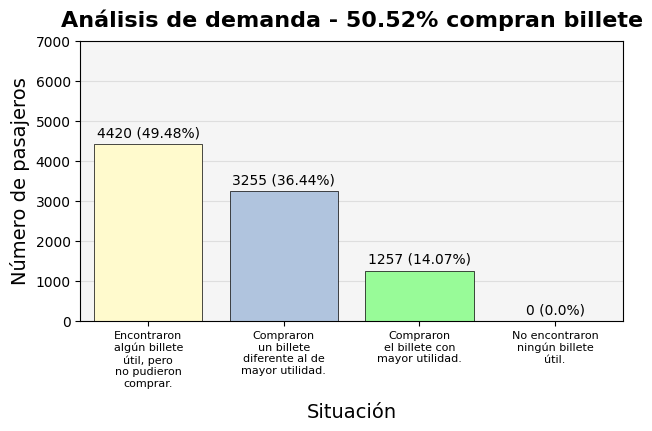

In [38]:
kernel_plotter.plot_demand_status(y_limit=7000, save_path='../reports/robin/demand_status_25.pdf')

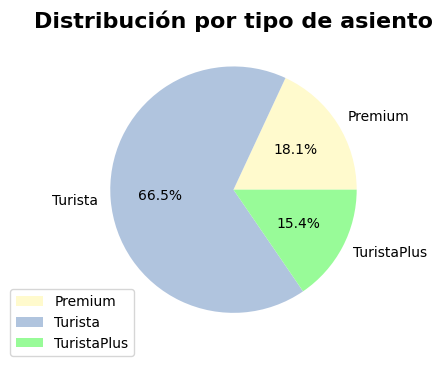

In [39]:
kernel_plotter.plot_seat_distribution_pie_chart(save_path='../reports/robin/seat_distribution_pie_chart_25.pdf')

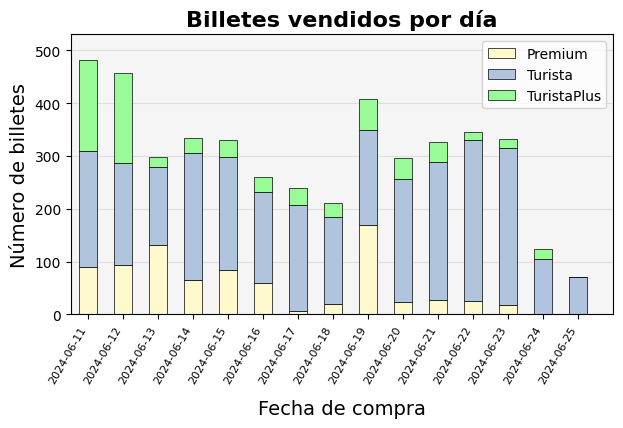

In [40]:
kernel_plotter.plot_tickets_by_date(save_path='../reports/robin/tickets_by_date_25.pdf')

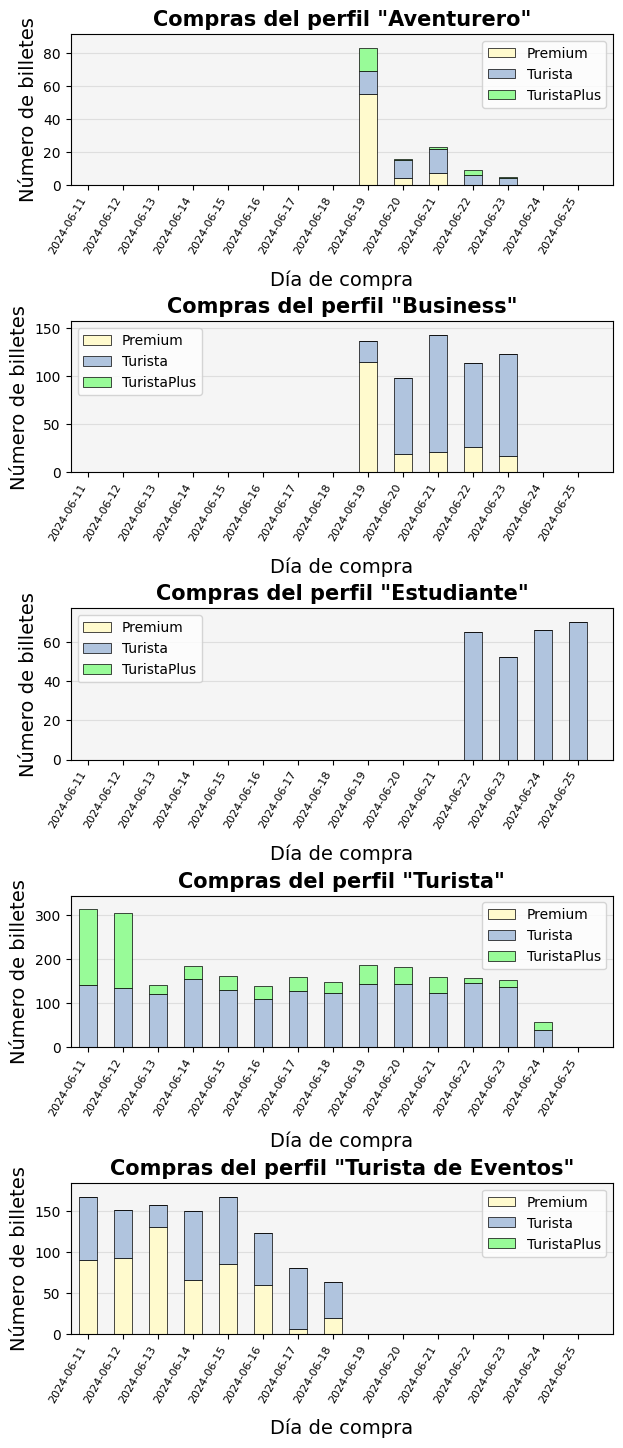

In [41]:
kernel_plotter.plot_tickets_by_user(save_path='../reports/robin/tickets_by_user_25.pdf')

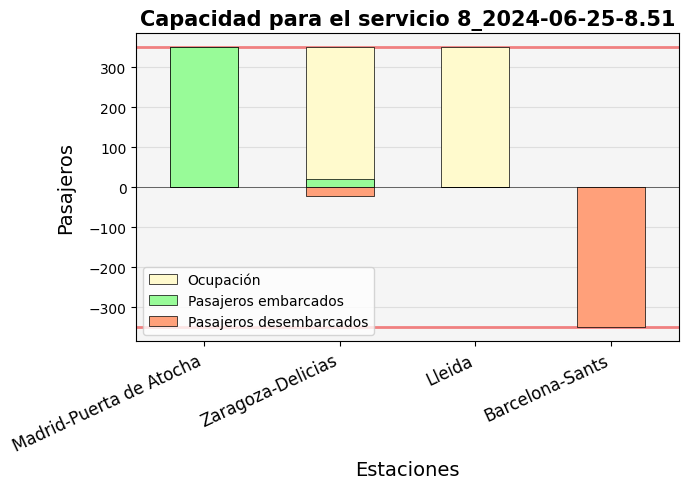

In [42]:
kernel_plotter.plot_service_capacity(service_id='8_2024-06-25-8.51',
                                     save_path='../reports/robin/service_capacity_8_2024-06-25-8.51_25.pdf')

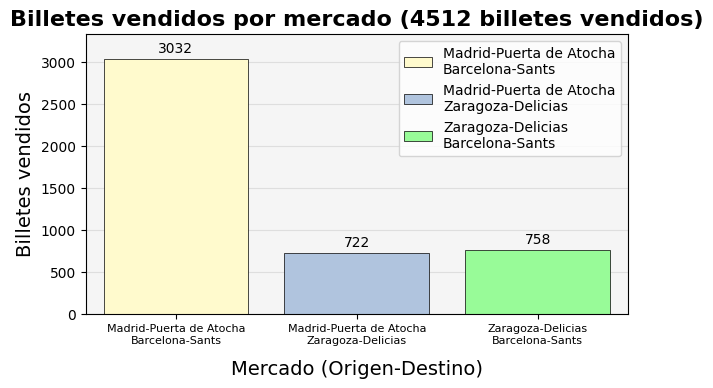

In [43]:
kernel_plotter.plot_tickets_by_pair(save_path='../reports/robin/tickets_by_pair_25.pdf')

## Load inference trace

In [44]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [45]:
# Copy trace file in reports
shutil.copyfile(trace_path, reports_path / 'inference_trace_25.json')

PosixPath('../reports/inference_trace_25.json')

In [73]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Turista': 2446,
 'Turista de Eventos': 1062,
 'Aventurero': 136,
 'Business': 615,
 'Estudiante': 253}

In [74]:
# Open output csv
output_df = pd.read_csv(f'../reports/robin/output_25.csv')

In [75]:
df = output_df.copy()
df['route'] = df['departure_station'] + '-' + df['arrival_station']
    
# Agrupar por 'user_pattern' y 'route', y contar el número de ocurrencias
grouped = df.groupby(['user_pattern', 'route']).size().reset_index(name='passengers')

# Crear el diccionario final
passenger_dict = {}
for _, row in grouped.iterrows():
    user_pattern = row['user_pattern']
    route = row['route']
    passengers = row['passengers']
    
    if user_pattern not in passenger_dict:
        passenger_dict[user_pattern] = {}
    
    passenger_dict[user_pattern][route] = passengers

In [76]:
# Convertir el diccionario en un DataFrame
df = pd.DataFrame(passenger_dict).T

# Calcular el número total de pasajeros para cada tipo (user_pattern)
df['Total Pasajeros'] = df.sum(axis=1)

# Calcular el número total de pasajeros en general
total_passengers = df['Total Pasajeros'].sum()

# Añadir una fila para el total general
df.loc['Total General'] = df.sum(axis=0)
df.at['Total General', 'Total Pasajeros'] = total_passengers

In [77]:
df

,Madrid-Barcelona,Madrid-Zaragoza,Zaragoza-Barcelona,Total Pasajeros
Aventurero,660,120,103,883
Business,1038,228,108,1374
Estudiante,657,316,309,1282
Turista,3374,407,393,4174
Turista de Eventos,995,136,88,1219
Total General,6724,1207,1001,8932


## Load user patterns and variables from demand config file

In [51]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [59]:
user_patterns = []
variables = {}
rules = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
    rules[user_pattern['name']] = [rule for rule in user_pattern['rules']]
                
print(user_patterns)
pprint.pp(variables)
pprint.pp(rules)

['Business', 'Estudiante', 'Turista', 'Turista de Eventos', 'Aventurero']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['RU1', 'RU2', 'RU3', 'RU4']}
{'Business': ['R0', 'R1', 'R2'],
 'Estudiante': ['R0', 'R1', 'R2', 'R3'],
 'Turista': ['R0', 'R1', 'R2', 'R3'],
 'Turista de Eventos': ['R0', 'R1', 'R2'],
 'Aventurero': ['R0', 'R1', 'R2']}


In [60]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]

In [61]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])

In [62]:
# Multicolumn pandas dataframes

for df in behaviour_dfs:
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), 3 * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    print(f'Variable: {df}')
    print(multicol_df)

Variable: origin
          Business                   Estudiante                   Turista  \
               Sum  Count Passengers        Sum  Count Passengers     Sum   
very_near    615.0  615.0      615.0      506.0  506.0      253.0  2446.0   
mid_range      0.0    0.0        0.0        0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0        0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0        0.0    0.0        0.0     0.0   

                             Turista de Eventos                    Aventurero  \
            Count Passengers                Sum   Count Passengers        Sum   
very_near  2446.0     2446.0             1062.0  1062.0     1062.0      136.0   
mid_range  2446.0     2446.0                0.0     0.0        0.0        0.0   
far           0.0        0.0                0.0     0.0        0.0        0.0   
far_away      0.0        0.0                0.0     0.0        0.0        0.0   

                             
   

In [63]:
rules_dfs = {}
columns = ['Consequent', 'Percentage']
for user_type in rules:
    rules_dfs[user_type] = pd.DataFrame(columns=rules[user_type], index=np.array(columns))
    
    # Fill dataframe with zeros
    for rule in rules[user_type]:
        for col in columns:
            rules_dfs[user_type].loc[col, rule] = np.float32(0.0)

In [64]:
def update_rules_dfs(rules_dfs: Mapping[str, pd.DataFrame],
                     user_pattern: str,
                     rules: List):
   
    for rule in rules:
        rules_dfs[user_pattern].loc['Consequent', rule['name']] += rule['result']

    return rules_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_rules_dfs(rules_dfs=rules_dfs,
                                     user_pattern=user_pattern,
                                     rules=trace[passenger]['trace_of_each_rule'])
    
# Round cells of dataframe to 2 decimals
for user_type in rules_dfs:
    rules_dfs[user_type] = rules_dfs[user_type].round(2)
    
    # Sum of values in 'Consequent' row
    sum_consequents = 0.0
    for col in rules_dfs[user_type].columns:
        sum_consequents += rules_dfs[user_type].loc['Consequent', col]
        
    # Update 'Percentage' row
    for col in rules_dfs[user_type].columns:
        rules_dfs[user_type].loc['Percentage', col] = f"{np.round(rules_dfs[user_type].loc['Consequent', col] / sum_consequents * 100, 2)} %"

for user_type in rules_dfs:
    print(f'User: {user_type}')
    #display(rules_dfs[user_type])
    print(rules_dfs[user_type])

User: Business
                 R0       R1        R2
Consequent  3992.21  7018.82  37023.12
Percentage   8.31 %  14.61 %   77.08 %
User: Estudiante
                 R0       R1       R2        R3
Consequent  2576.82  5082.48  2547.91  15092.79
Percentage  10.19 %  20.09 %  10.07 %   59.66 %
User: Turista
                     R0        R1        R2         R3
Consequent  23762.11872  24546.45  42876.23  122218.53
Percentage      11.13 %    11.5 %   20.09 %    57.27 %
User: Turista de Eventos
                  R0            R1        R2
Consequent  26514.27  41709.495733  26654.62
Percentage   27.95 %       43.96 %   28.09 %
User: Aventurero
                    R0       R1      R2
Consequent  6357.06106  4770.09   252.5
Percentage     55.86 %  41.92 %  2.22 %
